# Ví dụ 1: 
Chúng ta vẫn bắt đầu với một ví dụ trên dữ liệu nhân tạo. Trước hết ta tạo một bộ dữ liệu có 200 mẫu
(N=200) phân đều vào 02 lớp – mỗi lớp 100 phần tử. Mỗi mẫu có 2 chiều (d=2). Dữ liệu sẽ được chúng ta tạo
bởi make_circles trong thư viện sklearn.dataset sao cho đường biên giữa các lớp là không tuyến tính.
Tiếp theo sử dụng thư viện sklearn để minh họa phương pháp Kernel Vector Machine với các hàm nhân khác
nhau và tiến hành thực hiện phân lớp trên bộ dữ liệu nói trên.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_circles

### Cách 1: 
Tự xây dựng các module từ thư viện Numpy:

Trước hết chúng ta cần xây dựng các loại hàm nhân (kernel) khác nhau (Linear, Poly, Gaussian hay rbf):

In [2]:
import numpy as np
from numpy import linalg
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, gamma = 1, r = 1, d=3):
    return (r + gamma*np.dot(x, y)) ** d

def gaussian_kernel(x, y, sigma=5.0):
    # gamma = 1.0/(2 * (sigma ** 2))
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Tiếp theo chúng ta xây dựng lớp SVM, trong đó có phần tạo dữ liệu (sẽ sử dụng circle của sklearn).

In [3]:
class SVM(object):
    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Solve Quadratic Programming problem
        K = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers a = \lambda
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
    
    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, X):
        return np.sign(self.project(X))

### Cách 2: 
Sử dụng thư viện sklearn:

Đoạn lệnh tạo dữ liệu

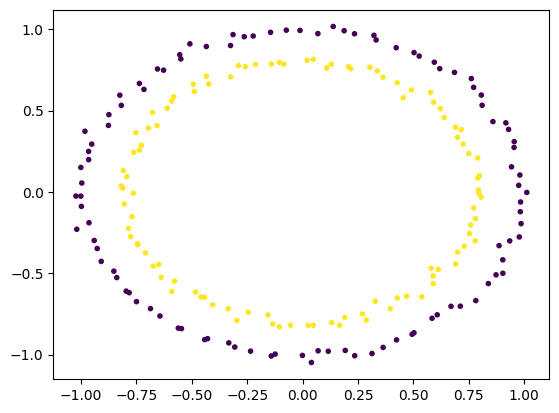

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import make_circles

# Generate dataset and targets
X, Y = make_circles(n_samples = 200, noise = 0.02)

# visualizing data
plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

Đoạn lệnh gọi thư viện và thực hiện quá trình phân loại, sau đó vẽ ra đường biên để quan sát

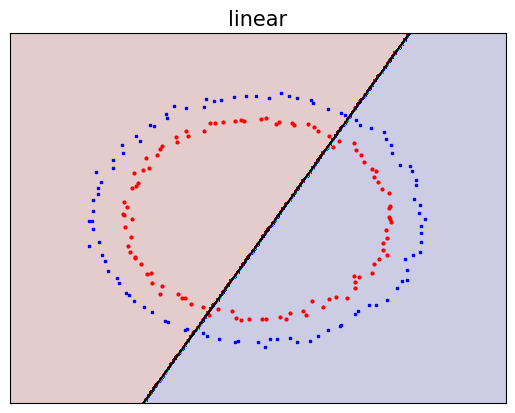

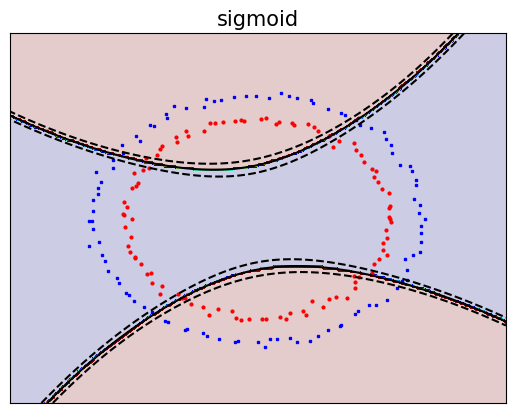

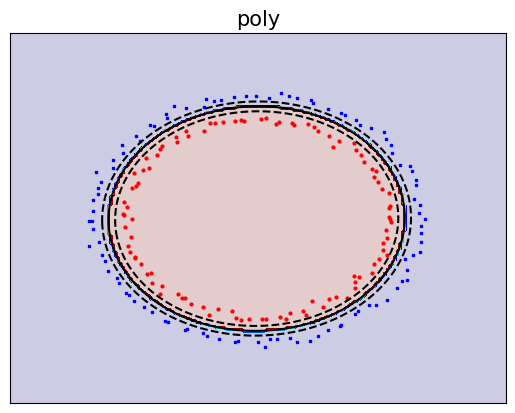

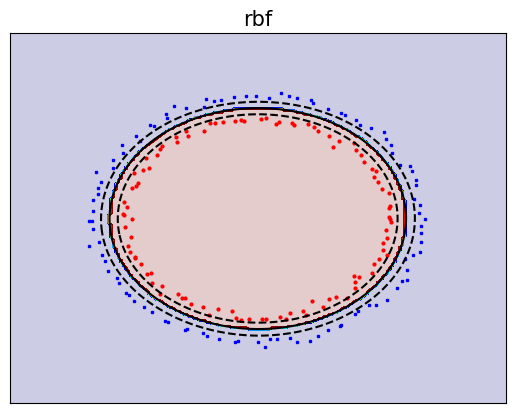

In [5]:
fignum = 1

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='None')
        plt.plot(X[Y==0, 0], X[Y==0, 1], 'bs', markersize = 2)
        plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
plt.show()

# Bài tập 1. 
Sử dụng thư viện để đưa ra độ chính xác Accuracy và ma trận nhầm lẫn Confusion Matrix theo mỗi phương pháp (Tham khảo code từ các bài trước).

In [6]:
X, Y = make_circles(n_samples = 200, noise = 0.02)

In [7]:
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.25, random_state = 0)

Kernel:  linear
Accuracy:  0.36
Confusion Matrix: 
[[ 8 12]
 [20 10]]

Kernel:  sigmoid
Accuracy:  0.62
Confusion Matrix: 
[[18  9]
 [10 13]]

Kernel:  poly
Accuracy:  1.0
Confusion Matrix: 
[[28  0]
 [ 0 22]]

Kernel:  rbf
Accuracy:  1.0
Confusion Matrix: 
[[28  0]
 [ 0 22]]



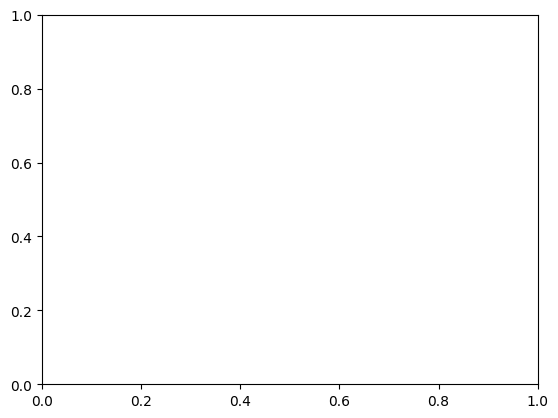

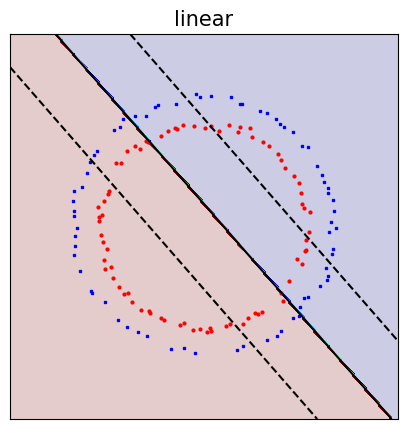

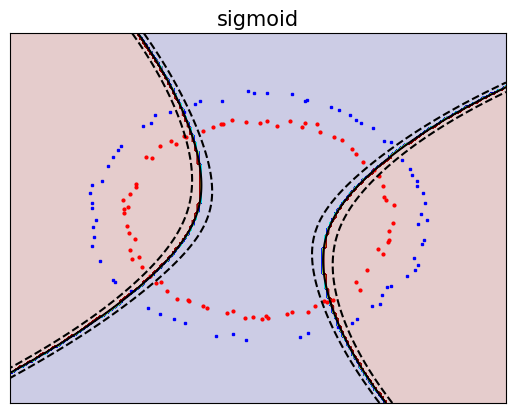

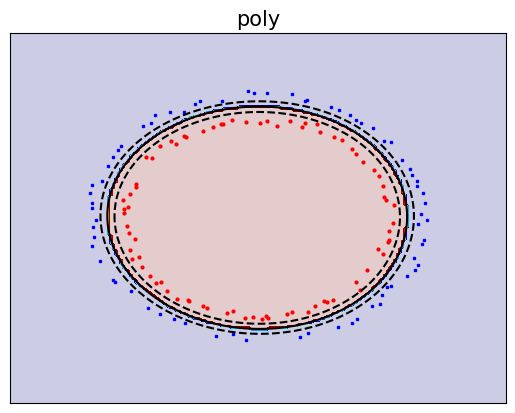

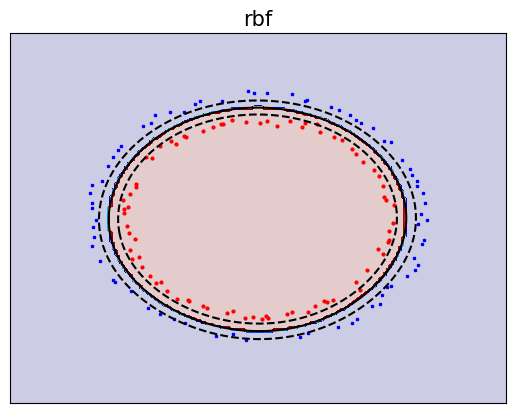

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(XTrain, yTrain)

    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='None')
        plt.plot(XTrain[yTrain==0, 0], XTrain[yTrain==0, 1], 'bs', markersize = 2)
        plt.plot(XTrain[yTrain==1, 0], XTrain[yTrain==1, 1], 'ro', markersize = 2)
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()

    
    yPred = clf.predict(XTest)

    print("Kernel: ", kernel)

    accuracy = accuracy_score(yPred, yTest)
    print("Accuracy: ", accuracy)

    cfs_matrix = confusion_matrix(yPred, yTest)
    print("Confusion Matrix: ")
    print(cfs_matrix)

    print("")
plt.show()

# Ví dụ 2. 
Trong ví dụ 2, chúng ta sử dụng dữ liệu kiểm tra chất lượng dự đoán liệu các vi mạch từ một nhà máy
chế tạo có đảm bảo chất lượng hay không. Tệp dữ liệu có trong file ex2data2.txt đính kèm. Dữ liệu quan sát gồm
2 chiều, đầu ra Y có dạng 0-1.
Dưới đây là đoạn lệnh đọc dữ liệu và vẽ ra màn hình

In [11]:
import numpy as np

file_path = "ex2data2.txt"
data = np.loadtxt(file_path, delimiter=',')

X = data[:, :-1]
Y = data[:, -1]

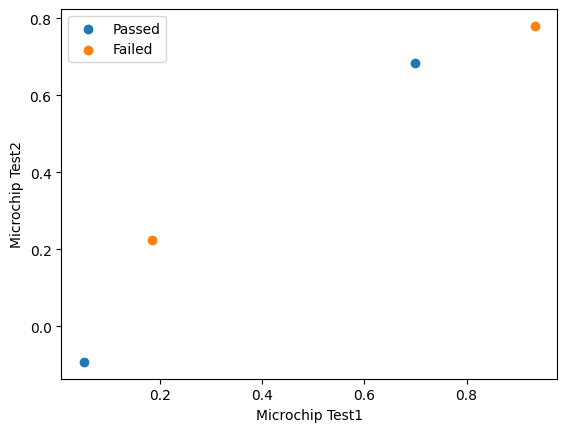

In [13]:
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import PdfPages

# visualizing data
mask = Y == 1
passed = plt.scatter(X[mask][0], X[mask][1])
failed = plt.scatter(X[~mask][0], X[~mask][1])
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

Tương tự Ví dụ 1, chúng ta sẽ sử dụng các nhân có trong thư viện sklearn để phân loại dữ liệu

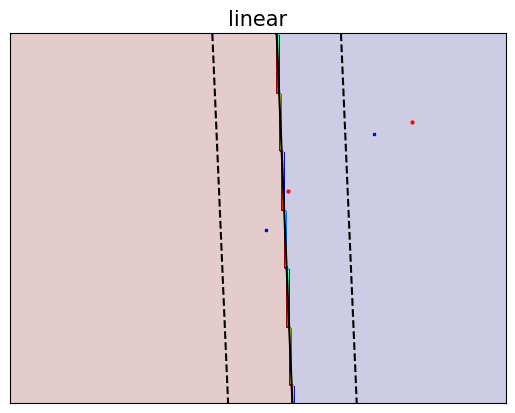

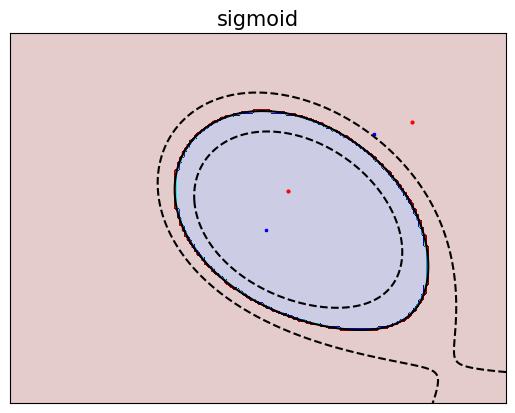

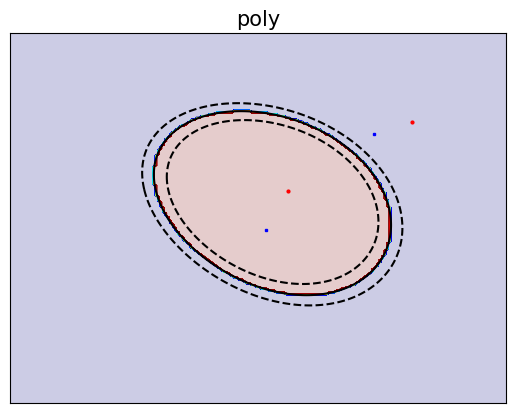

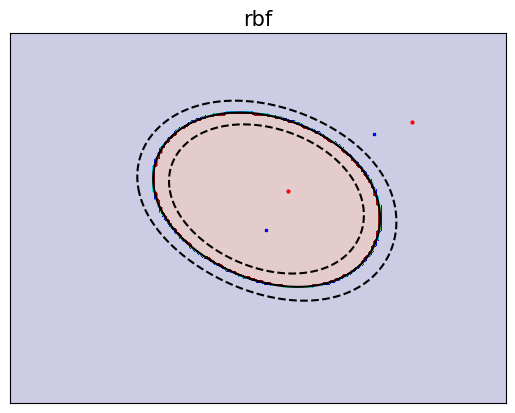

In [14]:
fignum = 1

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    with PdfPages(kernel + '3.pdf') as pdf:
        # plot the line, the points, and the nearest vectors to the plane
        fig, ax = plt.subplots()
        plt.figure(fignum, figsize=(5, 5))
        plt.clf()
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='None')
        plt.plot(X[mask][0], X[mask][1], 'bs', markersize = 2)
        plt.plot(X[~mask][0], X[~mask][1], 'ro', markersize = 2)
        plt.axis('tight')
        x_min = -1.5
        x_max = 1.5
        y_min = -1.5
        y_max = 1.5
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.figure(fignum, figsize=(5, 5))
        CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
        plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
        levels=[-.5, 0, .5])
        plt.title(kernel, fontsize = 15)
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.xticks(())
        plt.yticks(())
        fignum = fignum + 1
        pdf.savefig()
plt.show()

# Bài tập tự thực hành 1. 
Cho tệp dữ liệu đính kèm ARgender.mat, đoạn lệnh sau đây sẽ đọc tệp dữ liệu đó và
chia làm hai phần dữ liệu Training và Test Data. Chú ý sửa lại đường dẫn đến file dữ liệu theo thiết lập của các
bạn:

In [15]:
import scipy.io as sio
from sklearn.svm import SVC

A = sio.loadmat('ARgender.mat')
X_train = A['Y_train'].T
X_test = A['Y_test'].T
print(X_train.shape)
N = 700
y_train = A['label_train'].reshape(N)
y_test = A['label_test'].reshape(N)

(700, 300)


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)

    print("Kernel: ", kernel)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)

    cfs_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: ")
    print(cfs_matrix)

    print("")

Kernel:  linear
Accuracy:  0.9028571428571428
Confusion Matrix: 
[[344   6]
 [ 62 288]]

Kernel:  sigmoid
Accuracy:  0.8942857142857142
Confusion Matrix: 
[[342   8]
 [ 66 284]]

Kernel:  poly
Accuracy:  0.9228571428571428
Confusion Matrix: 
[[330  20]
 [ 34 316]]

Kernel:  rbf
Accuracy:  0.9085714285714286
Confusion Matrix: 
[[341   9]
 [ 55 295]]



# Bài tập tự thực hành 2. 
Cho tệp dữ liệu đính kèm dataset.csv, đoạn lệnh sau đây sẽ đọc tệp dữ liệu đó và chia
làm hai phần dữ liệu Training và Test Data. Chú ý sửa lại đường dẫn đến file dữ liệu theo thiết lập của các bạn:

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
dataset = pd.read_csv('dataset.csv')
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Chuyển vị ma trận dữ liệu do ta đọc bằng Pandas => mỗi record là 1 dong
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(XTrain, yTrain)
    
    yPred = clf.predict(XTest)

    print("Kernel: ", kernel)

    accuracy = accuracy_score(yPred, yTest)
    print("Accuracy: ", accuracy)

    cfs_matrix = confusion_matrix(yPred, yTest)
    print("Confusion Matrix: ")
    print(cfs_matrix)

    print("")

Kernel:  linear
Accuracy:  0.9
Confusion Matrix: 
[[66  8]
 [ 2 24]]

Kernel:  sigmoid
Accuracy:  0.7
Confusion Matrix: 
[[53 15]
 [15 17]]

Kernel:  poly
Accuracy:  0.93
Confusion Matrix: 
[[64  3]
 [ 4 29]]

Kernel:  rbf
Accuracy:  0.93
Confusion Matrix: 
[[64  3]
 [ 4 29]]



# Bài tập tự thực hành 3. 
Hãy thực hiện các yêu cầu như hai bài tập tự thực hành 1 và 2 với bài toán phân loại
tập dữ liệu ung thư vú. Dữ liệu này có sẵn trong sklearn.dataset, chúng ta có thể dùng đoạn lệnh sau để tải dữ
liệu từ thư viện này và hiện thị các trường của dữ liệu để dễ theo dõi:

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

# Breast cancer dataset for classification
data = load_breast_cancer()
print (data.feature_names)
print (data.target_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']


In [20]:
X = data.data
y = data.target

y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [21]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.25, random_state = 0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
XTrain = sc.fit_transform(XTrain)
XTest = sc.transform(XTest)

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import svm

# fit the model
for kernel in ('linear','sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(XTrain, yTrain)
    
    yPred = clf.predict(XTest)

    print("Kernel: ", kernel)

    accuracy = accuracy_score(yPred, yTest)
    print("Accuracy: ", accuracy)

    cfs_matrix = confusion_matrix(yPred, yTest)
    print("Confusion Matrix: ")
    print(cfs_matrix)

    print("")

Kernel:  linear
Accuracy:  0.972027972027972
Confusion Matrix: 
[[51  2]
 [ 2 88]]

Kernel:  sigmoid
Accuracy:  0.8951048951048951
Confusion Matrix: 
[[45  7]
 [ 8 83]]

Kernel:  poly
Accuracy:  0.9440559440559441
Confusion Matrix: 
[[49  4]
 [ 4 86]]

Kernel:  rbf
Accuracy:  0.6293706293706294
Confusion Matrix: 
[[ 0  0]
 [53 90]]

